## VAE

Source: https://github.com/pytorch/examples/tree/master/vae

### setup

In [1]:
import argparse
import time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchnet.meter import AverageValueMeter

In [4]:
import mnist

In [5]:
parser = {
    'data_path': '../data/mnist/',
    'epochs': 10,
    'batch_size': 128,
    'cuda': True,
    'seed': 7,
    'workers': 4
}
args = argparse.Namespace(**parser)

args.cuda = args.cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

### model

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400) # image size = 28x28
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3)) # sigmoid force output in (0,1)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

### train

In [7]:
def loss_function(recon_function, recon_x, x, mu, logvar):
    BCE = recon_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add(logvar.exp()).mul(-1).add(1).add(logvar)
    KLD = torch.sum(KLD_element).mul(-0.5)

    return BCE, KLD, BCE + KLD

In [8]:
def train(args, train_loader, model, recon_function, optimizer, epoch):
    model.train()
    losses = AverageValueMeter()
    kl_losses = AverageValueMeter()
    recon_losses = AverageValueMeter()
    start = time.time()
    
    for i, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        kl_loss, recon_loss, loss = loss_function(
            recon_function, recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        losses.add(loss.data.cpu()[0], data.size(0))
        kl_losses.add(loss.data.cpu()[0], data.size(0))
        recon_losses.add(recon_loss.data.cpu()[0], data.size(0))

    print("=> EPOCH {} | Time: {}s | Loss: {:.4f}"
          " | KL_loss: {:.4f} | Recon_loss: {:.4f}"
          .format(epoch, round(time.time()-start), losses.value()[0],
                  kl_losses.value()[0], recon_losses.value()[0]))

In [9]:
def validate(args, val_loader, model, recon_function, epoch):
    model.eval()
    losses = AverageValueMeter()
    start = time.time()
    
    for data, _ in val_loader:
        if args.cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        losses.add(loss_function(recon_function, recon_batch,
                                 data, mu, logvar)[2].data[0],
                   data.size(0))

    print("   % VALIDATE | Time: {}s | Loss: {:.4f}"
          .format(round(time.time()-start), losses.value()[0]))

### prepare

In [10]:
train_loader = DataLoader(
    mnist.MNIST(args.data_path, train=True, download=True,
                transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
val_loader = DataLoader(
    mnist.MNIST(args.data_path, train=False,
                transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

In [11]:
model = VAE()
recon_function = nn.BCELoss(size_average=False)
if args.cuda:
    model.cuda()
    recon_function.cuda()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### run

In [13]:
for epoch in range(1, args.epochs + 1):
    train(args, train_loader, model, recon_function, optimizer, epoch)
    validate(args, val_loader, model, recon_function, epoch)

=> EPOCH 1 | Time: 3s | Loss: 163.4164 | KL_loss: 163.4164 | Recon_loss: 15.4997
   % VALIDATE | Time: 0s | Loss: 126.8053
=> EPOCH 2 | Time: 3s | Loss: 120.9831 | KL_loss: 120.9831 | Recon_loss: 22.1429
   % VALIDATE | Time: 0s | Loss: 115.4571
=> EPOCH 3 | Time: 3s | Loss: 114.4720 | KL_loss: 114.4720 | Recon_loss: 23.6108
   % VALIDATE | Time: 0s | Loss: 111.7128
=> EPOCH 4 | Time: 3s | Loss: 111.5083 | KL_loss: 111.5083 | Recon_loss: 24.1908
   % VALIDATE | Time: 0s | Loss: 109.4797
=> EPOCH 5 | Time: 3s | Loss: 109.7404 | KL_loss: 109.7404 | Recon_loss: 24.4694
   % VALIDATE | Time: 0s | Loss: 108.2385
=> EPOCH 6 | Time: 3s | Loss: 108.5703 | KL_loss: 108.5703 | Recon_loss: 24.6725
   % VALIDATE | Time: 0s | Loss: 107.7010
=> EPOCH 7 | Time: 3s | Loss: 107.7033 | KL_loss: 107.7033 | Recon_loss: 24.8036
   % VALIDATE | Time: 0s | Loss: 106.8678
=> EPOCH 8 | Time: 3s | Loss: 107.1016 | KL_loss: 107.1016 | Recon_loss: 24.9433
   % VALIDATE | Time: 0s | Loss: 106.2570
=> EPOCH 9 | Tim

### generate

In [15]:
data, _ = iter(val_loader).next()
if args.cuda:
    data = data.cuda()

data = Variable(data, volatile=True)
recon_batch, mu, logvar = model(data)
recon = recon_batch.view(-1, 1, 28, 28)

In [16]:
sample = data.data[0, 0].cpu().numpy()
recon_sample = recon.data[0, 0].cpu().numpy()

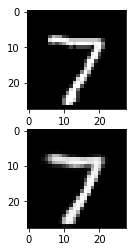

In [17]:
plt.subplot(211)
plt.imshow(sample, vmin=0, vmax=1, cmap="gray")
plt.subplot(212)
plt.imshow(recon_sample, vmin=0, vmax=1, cmap="gray")

## Conditional VAE

Source: https://github.com/wiseodd/generative-models/tree/master/VAE/conditional_vae

### setup

In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchnet.meter import AverageValueMeter

In [4]:
import mnist

In [5]:
mb_size = 64
epochs = 100
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128 # number of hidden unit
lr = 1e-3

intermediate_path = '../intermediate/cvae/'
if not os.path.isdir(intermediate_path):
    os.makedirs(intermediate_path)
    
data_path = '../data/mnist/'
    
torch.manual_seed(7)

### model

In [6]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [7]:
Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

In [8]:
Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

In [9]:
Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

In [10]:
def Q(X, c):
    inputs = torch.cat([X, c], 1)
    h = F.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_logvar = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_logvar

In [11]:
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mu.size(0), Z_dim))
    return mu + torch.exp(log_var / 2) * eps

In [12]:
Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

In [13]:
def P(z, c):
    inputs = torch.cat([z, c], 1)
    h = F.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

### train

In [14]:
def train(data_loader, solver, epoch):
    losses = AverageValueMeter()
    
    for i, (X, c) in enumerate(train_loader):
        X = X.view(-1, 784)
        c_onehot = torch.zeros(c.size(0), y_dim).scatter_(
            1, c.unsqueeze(1), 1)
        X = Variable(X)
        c_onehot = Variable(c_onehot)

        # Forward
        z_mu, z_logvar = Q(X, c_onehot)
        z = sample_z(z_mu, z_logvar)
        X_sample = P(z, c_onehot)

        # Loss
        recon_loss = F.binary_cross_entropy(X_sample, X, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(z_logvar)
                                  + z_mu**2 - 1 - z_logvar)
        loss = recon_loss + kl_loss
        
        # Backward
        loss.backward()
        solver.step()
        
        for p in params:
            p.grad.data.zero_()
        
        losses.add(loss.data[0], X.size(0))
    
    print("=> EPOCH {} | Loss: {:.4f}"
          .format(epoch, losses.value()[0]))

### utils

In [15]:
def plot(samples, epoch):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(sample.reshape(28, 28), cmap="Greys_r")

    out_filepath = os.path.join(intermediate_path, 
                                "{}.png".format(str(epoch).zfill(3)))
    plt.savefig(out_filepath, bbox_inches='tight')
    plt.close(fig)

### prepare

In [16]:
train_loader = DataLoader(
    mnist.MNIST(data_path, train=True, download=True,
                transform=transforms.ToTensor()),
    batch_size=mb_size, shuffle=True)

In [17]:
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

In [19]:
for epoch in range(1, epochs+1):
    train(train_loader, solver, epoch)
    c = torch.from_numpy(np.random.randint(0, 10, mb_size))
    c_onehot = torch.zeros(c.size(0), y_dim).scatter_(1, c.unsqueeze(1), 1)
    z = torch.randn(mb_size, Z_dim)
    samples = P(Variable(z), Variable(c_onehot)).data.numpy()[:16]
    plot(samples, epoch)

=> EPOCH 1 | Loss: 183.9763
=> EPOCH 2 | Loss: 135.6942
=> EPOCH 3 | Loss: 123.3090
=> EPOCH 4 | Loss: 116.8960
=> EPOCH 5 | Loss: 113.2857
=> EPOCH 6 | Loss: 111.1799
=> EPOCH 7 | Loss: 109.7620
=> EPOCH 8 | Loss: 108.6592
=> EPOCH 9 | Loss: 107.9670
=> EPOCH 10 | Loss: 107.3998
=> EPOCH 11 | Loss: 106.8704
=> EPOCH 12 | Loss: 106.4485
=> EPOCH 13 | Loss: 106.1208
=> EPOCH 14 | Loss: 105.8686
=> EPOCH 15 | Loss: 105.6030
=> EPOCH 16 | Loss: 105.3722
=> EPOCH 17 | Loss: 105.1703
=> EPOCH 18 | Loss: 104.9846
=> EPOCH 19 | Loss: 104.8853
=> EPOCH 20 | Loss: 104.6661
=> EPOCH 21 | Loss: 104.5560
=> EPOCH 22 | Loss: 104.4186
=> EPOCH 23 | Loss: 104.2742
=> EPOCH 24 | Loss: 104.2110
=> EPOCH 25 | Loss: 104.0873
=> EPOCH 26 | Loss: 103.9460
=> EPOCH 27 | Loss: 103.8903
=> EPOCH 28 | Loss: 103.7722
=> EPOCH 29 | Loss: 103.7146
=> EPOCH 30 | Loss: 103.6487
=> EPOCH 31 | Loss: 103.5393
=> EPOCH 32 | Loss: 103.4941
=> EPOCH 33 | Loss: 103.3744
=> EPOCH 34 | Loss: 103.3083
=> EPOCH 35 | Loss: 103

## Denoising VAE

Source: https://github.com/wiseodd/generative-models/tree/master/VAE/denoising_vae

### setup

In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchnet.meter import AverageValueMeter

In [4]:
import mnist

In [5]:
mb_size = 64
epochs = 100
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128 # number of hidden unit
lr = 1e-3
noise_factor = .25

intermediate_path = '../intermediate/dvae/'
if not os.path.exists(intermediate_path):
    os.makedirs(intermediate_path)
    
data_path = '../data/mnist/'

torch.manual_seed(7)

### model

In [6]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [7]:
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

In [8]:
def Q(X):
    h = F.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

def sample_z(mu, log_var):
    eps = Variable(torch.randn(mu.size(0), Z_dim))
    return mu + torch.exp(log_var / 2) * eps

In [9]:
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

In [10]:
def P(z):
    h = F.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

### utils

In [11]:
def plot(samples, epoch):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(sample.reshape(28, 28), cmap="Greys_r")

    out_filepath = os.path.join(intermediate_path, 
                                "{}.png".format(str(epoch).zfill(3)))
    plt.savefig(out_filepath, bbox_inches='tight')
    plt.close(fig)

### train

In [17]:
def train(train_loader, solver, epoch):
    losses = AverageValueMeter()
    
    for i, (X, _) in enumerate(train_loader):
        X = X.view(-1, 784)
        X = Variable(X)
        
        # Add noise
        X_noise = X + noise_factor * Variable(torch.randn(X.size()))
        X_noise.data.clamp_(0., 1.)

        # Forward
        z_mu, z_logvar = Q(X_noise)
        z = sample_z(z_mu, z_logvar)
        X_sample = P(z)

        # Loss
        recon_loss = F.binary_cross_entropy(X_sample, X, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(z_logvar)
                                  + z_mu**2 - 1 - z_logvar)
        loss = recon_loss + kl_loss
        
        # Backward
        loss.backward()
        solver.step()
    
        for p in params:
            p.grad.data.zero_()
        
        losses.add(loss.data[0], X.size(0))
    
    print("=> EPOCH {} | Loss: {:.4f}"
          .format(epoch, losses.value()[0]))

### prepare

In [13]:
""" Training """
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

In [15]:
train_loader = DataLoader(
    mnist.MNIST(data_path, train=True, download=True,
                transform=transforms.ToTensor()),
    batch_size=mb_size, shuffle=True)

### run

In [18]:
for epoch in range(1, epochs+1):
    train(train_loader, solver, epoch)
    z = torch.randn(mb_size, Z_dim)
    samples = P(Variable(z)).data.numpy()[:16]
    plot(samples, epoch)

=> EPOCH 1 | Loss: 194.1767
=> EPOCH 2 | Loss: 147.8750
=> EPOCH 3 | Loss: 135.4952
=> EPOCH 4 | Loss: 128.0893
=> EPOCH 5 | Loss: 123.8210
=> EPOCH 6 | Loss: 121.3719
=> EPOCH 7 | Loss: 119.9865
=> EPOCH 8 | Loss: 118.9402
=> EPOCH 9 | Loss: 118.2988
=> EPOCH 10 | Loss: 117.7279
=> EPOCH 11 | Loss: 117.2896
=> EPOCH 12 | Loss: 116.9489
=> EPOCH 13 | Loss: 116.7146
=> EPOCH 14 | Loss: 116.4792
=> EPOCH 15 | Loss: 116.2661
=> EPOCH 16 | Loss: 116.0227
=> EPOCH 17 | Loss: 115.8309
=> EPOCH 18 | Loss: 115.6137
=> EPOCH 19 | Loss: 115.5089
=> EPOCH 20 | Loss: 115.3506
=> EPOCH 21 | Loss: 115.2817
=> EPOCH 22 | Loss: 115.1794
=> EPOCH 23 | Loss: 115.1692
=> EPOCH 24 | Loss: 115.0326
=> EPOCH 25 | Loss: 114.9706
=> EPOCH 26 | Loss: 114.9115
=> EPOCH 27 | Loss: 114.8957
=> EPOCH 28 | Loss: 114.8248
=> EPOCH 29 | Loss: 114.7825
=> EPOCH 30 | Loss: 114.7367
=> EPOCH 31 | Loss: 114.6962
=> EPOCH 32 | Loss: 114.6539
=> EPOCH 33 | Loss: 114.5837
=> EPOCH 34 | Loss: 114.5739
=> EPOCH 35 | Loss: 114